<a href="https://colab.research.google.com/github/techmehedi/CSC36000-Project-Mehedi-Aidan/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quick Test - 10 tasks, all strategies
Uniform     :  80.0% success, Energy:   1423, Efficiency: 0.0562
SDF         :  90.0% success, Energy:   1163, Efficiency: 0.0774
LARA        :  90.0% success, Energy:    869, Efficiency: 0.1036
UARA        :  60.0% success, Energy:   1274, Efficiency: 0.0471
UARA+LARA   :  80.0% success, Energy:   1523, Efficiency: 0.0525

Starting Full Scalability Analysis
Running Scalability Tests...
  Tasks: 10... Done
  Tasks: 20... Done
  Tasks: 30... Done
  Tasks: 40... Done
  Tasks: 50... Done
  Tasks: 60... Done


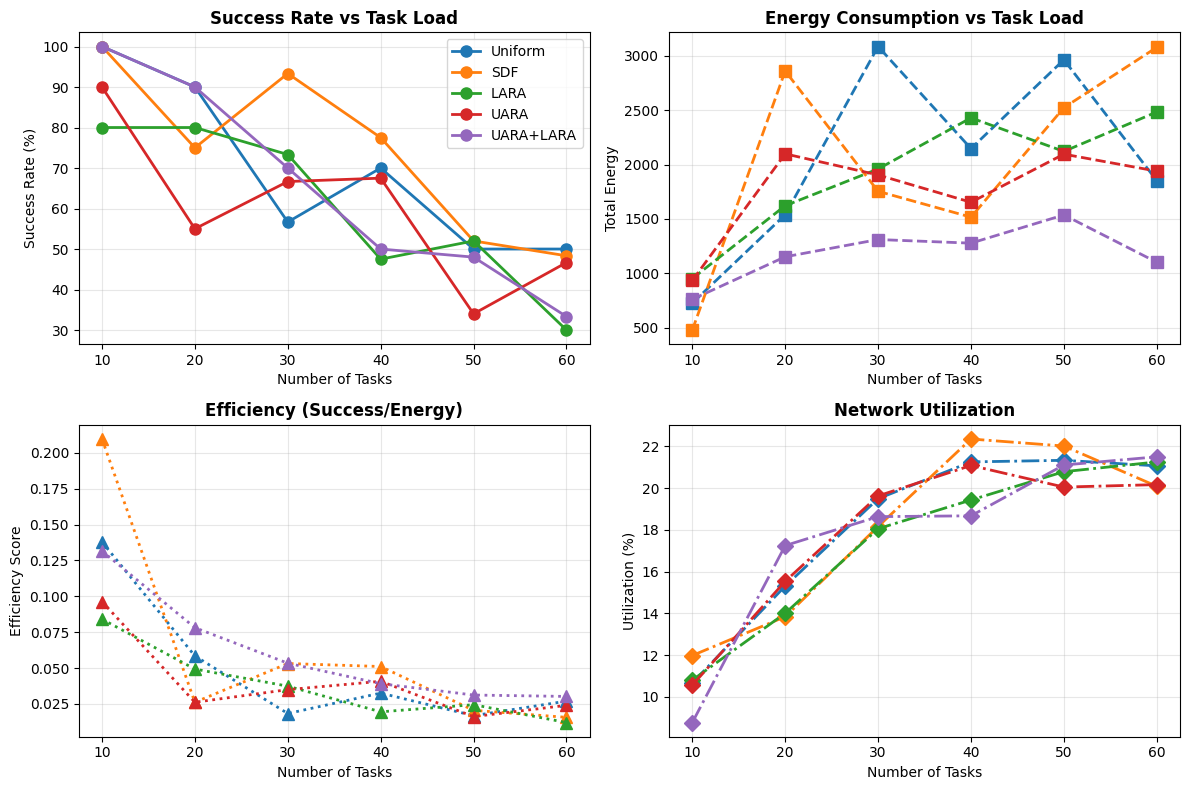


PERFORMANCE SUMMARY (60 tasks)
Strategy     Success %  Latency    Energy     Efficiency  
----------------------------------------------------------------------
Uniform      50.0      27.4      1852      0.0270     
SDF          48.3      32.6      3080      0.0157     
LARA         30.0      29.0      2485      0.0121     
UARA         46.7      28.5      1940      0.0241     
UARA+LARA    33.3      32.2      1101      0.0303     


In [1]:
"""Distributed Task Scheduling: Edge Cluster + Network + Energy"""

import numpy as np
import random
from dataclasses import dataclass, field
from typing import List, Dict, Callable
import matplotlib.pyplot as plt

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# ------------------------------------------------------------
# System Configuration
# ------------------------------------------------------------

# Edge Cluster Settings
NUM_EDGE_SERVERS = 5
POWER_PER_SERVER = 30.0
TOTAL_CLUSTER_POWER = NUM_EDGE_SERVERS * POWER_PER_SERVER

# Network Settings - Now actually used!
NETWORK_BANDWIDTH = 100.0
AVG_NETWORK_DELAY = 3  # Now actually affects transmission

# Energy Settings
ENERGY_PER_SAMPLE = 0.5
ENERGY_IDLE = 0.1

# ------------------------------------------------------------
# Task Model
# ------------------------------------------------------------

@dataclass
class Task:
    tid: int
    arrival: int
    deadline: int
    eps: float
    true_a: float
    true_b: float
    max_rate: float
    data_size: float

    # State tracking
    progress: float = 0.0
    transferred: float = 0.0
    transmission_delay: int = 0  # Track network delay

    # Status flags
    is_transmitting: bool = True
    ready_to_compute: bool = False
    done: bool = False
    missed: bool = False

    # Metrics
    completion_time: int = -1

    # LARA estimation history
    history_s: List[float] = field(default_factory=list)
    history_l: List[float] = field(default_factory=list)

    def true_loss(self) -> float:
        s = max(self.progress, 1.0)
        noise = np.random.normal(loc=0.0, scale=0.02)
        return max(self.true_a * (s ** (-self.true_b)) + noise, 1e-4)

    def observe(self):
        loss = self.true_loss()
        self.history_s.append(max(self.progress, 1.0))
        self.history_l.append(loss)
        return loss

# ------------------------------------------------------------
# Task Generator
# ------------------------------------------------------------

def create_tasks(num_tasks: int = 10, arrival_range: int = 20) -> List[Task]:
    tasks = []

    for i in range(num_tasks):
        t_arrival = np.random.randint(0, arrival_range)
        a = np.random.uniform(0.8, 1.5)
        b = np.random.uniform(0.2, 0.7)
        deadline = t_arrival + np.random.randint(20, 50)
        eps = np.random.uniform(0.12, 0.22)
        max_rate = np.random.uniform(20, 50)
        data_size = np.random.uniform(30, 100)

        task = Task(
            tid=i,
            arrival=t_arrival,
            deadline=deadline,
            eps=eps,
            true_a=a,
            true_b=b,
            max_rate=max_rate,
            data_size=data_size
        )
        tasks.append(task)
    return tasks

# ------------------------------------------------------------
# Estimation Logic (LARA) - Improved stability
# ------------------------------------------------------------

def estimate_remaining_samples(task: Task, gamma: float = 0.9) -> float:
    if len(task.history_s) < 2:
        # Initial rough estimate based on task parameters
        return (task.true_a / task.eps) ** (1.0 / task.true_b)

    s_hist = np.array(task.history_s, dtype=float)
    l_hist = np.array(task.history_l, dtype=float)

    if len(s_hist) < 2:
        return (task.true_a / task.eps) ** (1.0 / task.true_b)

    mask = (s_hist > 0) & (l_hist > 0)
    s_hist = s_hist[mask]
    l_hist = l_hist[mask]

    if len(s_hist) < 2:
        return (task.true_a / task.eps) ** (1.0 / task.true_b)

    x = np.log(s_hist)
    y = np.log(l_hist)

    try:
        # Simple linear fit without weights for stability
        slope, intercept = np.polyfit(x, y, 1)
        b_hat = max(-slope, 0.1)  # Prevent negative or zero
        a_hat = max(np.exp(intercept), 0.1)

        s_target = (a_hat / task.eps) ** (1.0 / b_hat)
        remaining = max(s_target - task.progress, 0.0)

        return float(min(remaining, 10000))  # Reasonable cap
    except:
        return (task.true_a / task.eps) ** (1.0 / task.true_b)

# ------------------------------------------------------------
# Schedulers
# ------------------------------------------------------------

EXPLORATION_SAMPLES = 100.0

def uniform_scheduler(t, tasks, compute_ids):
    if not compute_ids:
        return {}
    frac = 1.0 / len(compute_ids)
    return {tid: frac for tid in compute_ids}

def sdf_scheduler(t, tasks, compute_ids):
    if not compute_ids:
        return {}

    sorted_ids = sorted(compute_ids, key=lambda i: tasks[i].deadline)

    alloc = {}
    remaining_power_frac = 1.0
    max_task_frac = POWER_PER_SERVER / TOTAL_CLUSTER_POWER

    for tid in sorted_ids:
        if remaining_power_frac <= 0:
            break
        chosen_frac = min(remaining_power_frac, max_task_frac)
        alloc[tid] = chosen_frac
        remaining_power_frac -= chosen_frac

    return alloc

def lara_scheduler(t, tasks, compute_ids):
    if not compute_ids:
        return {}

    # Dynamic exploration based on system load
    explore_threshold = 100.0 if len(compute_ids) < 10 else 50.0
    explore_ids = [tid for tid in compute_ids if tasks[tid].progress < explore_threshold]

    if explore_ids:
        frac = min(1.0, len(explore_ids) * (POWER_PER_SERVER / TOTAL_CLUSTER_POWER)) / len(explore_ids)
        return {tid: frac for tid in explore_ids}

    # Smart allocation
    task_needs = []
    for tid in compute_ids:
        task = tasks[tid]
        remaining = estimate_remaining_samples(task)
        time_left = max(task.deadline - t, 1)

        if time_left <= 0:
            continue

        needed_rate = remaining / time_left
        needed_frac = needed_rate / TOTAL_CLUSTER_POWER
        task_needs.append((tid, needed_frac, time_left))

    # Sort by urgency (smallest time_left first) then by needed rate
    task_needs.sort(key=lambda x: (x[2], x[1]))

    alloc = {}
    used_frac = 0.0
    max_server_frac = POWER_PER_SERVER / TOTAL_CLUSTER_POWER

    for tid, needed, time_left in task_needs:
        if used_frac >= 1.0:
            break

        # Urgent tasks get more
        urgency_boost = 1.5 if time_left < 5 else 1.0
        grant = min(needed * urgency_boost, max_server_frac)
        grant = min(grant, 1.0 - used_frac)

        if grant > 0.01:
            alloc[tid] = grant
            used_frac += grant

    return alloc

# ------------------------------------------------------------
# UARA: Better Network-Aware Resource Allocation
# ------------------------------------------------------------

def uara_network_allocator(tasks, active_ids, network_busyness):
    """
    network_busyness: 0-1 value indicating how busy the network is
    """
    if not active_ids:
        return {}

    # More realistic pricing based on actual network load
    congestion_price = 1.0 + (2.0 * network_busyness)  # 1-3 range

    caps = {}
    total_weight = 0.0

    for tid in active_ids:
        task = tasks[tid]

        # Better priority calculation using actual progress
        slack = max(task.deadline - task.transmission_delay, 1)
        progress_factor = 1.0 + (task.progress / max(task.data_size, 1))

        weight = (1.0 / slack) * progress_factor
        caps[tid] = weight
        total_weight += weight

    if total_weight > 0:
        # Normalize and apply congestion pricing
        for tid in caps:
            caps[tid] = caps[tid] / total_weight
            caps[tid] = caps[tid] / congestion_price  # Reduce allocation when network busy

    return caps

# ------------------------------------------------------------
# Simulation Engine - Now uses network delay
# ------------------------------------------------------------

def run_simulation(strategy_name, scheduler, use_uara=False,
                   num_tasks=10, horizon=100, verbose=False):

    tasks = create_tasks(num_tasks)

    completed = []
    missed = []
    total_energy = 0.0
    network_utilization = 0.0

    if verbose:
        print(f"=== {strategy_name} (Tasks: {num_tasks}) ===")

    for t in range(horizon):
        # 1. Identify tasks present
        present_ids = [
            task.tid for task in tasks
            if task.arrival <= t and not task.done and not task.missed
        ]

        # Deadline checks
        for tid in present_ids:
            task = tasks[tid]
            if t > task.deadline:
                task.missed = True
                missed.append(tid)

        active_ids = [
            tid for tid in present_ids
            if not tasks[tid].done and not tasks[tid].missed
        ]

        if not active_ids:
            continue

        # --------------------------------------------------------
        # 2. Network Phase with delay
        # --------------------------------------------------------
        transmitting_ids = [
            tid for tid in active_ids
            if tasks[tid].is_transmitting
        ]

        if transmitting_ids:
            bandwidth_share = NETWORK_BANDWIDTH / len(transmitting_ids)
            step_transfer = 0.0

            for tid in transmitting_ids:
                task = tasks[tid]

                # Apply network delay: can't transfer immediately
                if task.transmission_delay < AVG_NETWORK_DELAY:
                    task.transmission_delay += 1
                    continue

                # Now actually transfer data
                jitter = np.random.uniform(0.8, 1.2)
                transfer = bandwidth_share * jitter
                task.transferred += transfer
                step_transfer += transfer

                if task.transferred >= task.data_size:
                    task.is_transmitting = False
                    task.ready_to_compute = True
                    task.history_s = [1.0]
                    task.history_l = [task.true_loss()]

            # Track network utilization
            network_utilization += step_transfer / NETWORK_BANDWIDTH

        # --------------------------------------------------------
        # 3. Computing Phase
        # --------------------------------------------------------
        compute_ids = [
            tid for tid in active_ids
            if tasks[tid].ready_to_compute
        ]

        if not compute_ids:
            continue

        # Observe task state
        for tid in compute_ids:
            tasks[tid].observe()

        # Task-level scheduler
        task_alloc = scheduler(t, tasks, compute_ids)

        # Network-level UARA caps (use actual network busyness)
        network_busyness = len(transmitting_ids) / max(len(active_ids), 1)
        uara_caps = (
            uara_network_allocator(tasks, compute_ids, network_busyness)
            if use_uara
            else {tid: 1.0 for tid in compute_ids}
        )

        step_processing_energy = 0.0
        current_step_load = 0.0

        for tid, frac in task_alloc.items():
            task = tasks[tid]

            # Apply UARA constraint
            effective_frac = min(frac, uara_caps.get(tid, 1.0))

            cluster_allocated = effective_frac * TOTAL_CLUSTER_POWER
            server_cap = min(cluster_allocated, POWER_PER_SERVER)
            actual_power = min(server_cap, task.max_rate)

            task.progress += actual_power
            step_processing_energy += actual_power * ENERGY_PER_SAMPLE
            current_step_load += actual_power

            if task.true_loss() <= task.eps:
                task.done = True
                task.completion_time = t
                completed.append(tid)

        # --------------------------------------------------------
        # 4. Energy Accounting
        # --------------------------------------------------------
        active_servers = np.ceil(current_step_load / POWER_PER_SERVER)
        idle_servers = max(NUM_EDGE_SERVERS - active_servers, 0)

        total_energy += (
            step_processing_energy
            + idle_servers * ENERGY_IDLE
        )

    # --------------------------------------------------------
    # Metrics - Now includes efficiency
    # --------------------------------------------------------
    success_rate = (len(completed) / num_tasks) * 100.0

    latencies = [
        tasks[tid].completion_time - tasks[tid].arrival
        for tid in completed
    ]
    avg_latency = np.mean(latencies) if latencies else 0.0

    # Efficiency metric: success per energy unit
    efficiency = success_rate / max(total_energy, 1)

    # Average network utilization
    avg_net_util = (network_utilization / horizon) * 100 if horizon > 0 else 0

    return {
        "success_rate": success_rate,
        "avg_latency": avg_latency,
        "total_energy": total_energy,
        "efficiency": efficiency,
        "completed_count": len(completed),
        "network_utilization": avg_net_util
    }

# ------------------------------------------------------------
# Scalability Tests & Better Graphs
# ------------------------------------------------------------

def run_scalability_test():
    task_counts = [10, 20, 30, 40, 50, 60]

    strategies = {
        "Uniform": (uniform_scheduler, False),
        "SDF": (sdf_scheduler, False),
        "LARA": (lara_scheduler, False),
        "UARA": (uniform_scheduler, True),
        "UARA+LARA": (lara_scheduler, True)
    }

    results = {
        name: {"sr": [], "lat": [], "eng": [], "eff": [], "net": []}
        for name in strategies
    }

    print("Running Scalability Tests...")
    for count in task_counts:
        print(f"  Tasks: {count}...", end=" ")
        for name, (sched, use_uara) in strategies.items():
            h = 60 + (count * 2)
            res = run_simulation(
                name,
                sched,
                use_uara=use_uara,
                num_tasks=count,
                horizon=h,
                verbose=False
            )

            results[name]["sr"].append(res["success_rate"])
            results[name]["lat"].append(res["avg_latency"])
            results[name]["eng"].append(res["total_energy"])
            results[name]["eff"].append(res["efficiency"])
            results[name]["net"].append(res["network_utilization"])
        print("Done")

    # --------------------------------------------------------
    # Better Graphs - Clean and clear
    # --------------------------------------------------------

    # 1. Success Rate
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    for name in strategies:
        plt.plot(task_counts, results[name]["sr"], marker='o', linewidth=2, markersize=8, label=name)
    plt.title("Success Rate vs Task Load", fontweight='bold')
    plt.xlabel("Number of Tasks")
    plt.ylabel("Success Rate (%)")
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')

    # 2. Energy Consumption
    plt.subplot(2, 2, 2)
    for name in strategies:
        plt.plot(task_counts, results[name]["eng"], marker='s', linewidth=2, markersize=8, label=name, linestyle='--')
    plt.title("Energy Consumption vs Task Load", fontweight='bold')
    plt.xlabel("Number of Tasks")
    plt.ylabel("Total Energy")
    plt.grid(True, alpha=0.3)

    # 3. Efficiency (Success per Energy)
    plt.subplot(2, 2, 3)
    for name in strategies:
        plt.plot(task_counts, results[name]["eff"], marker='^', linewidth=2, markersize=8, label=name, linestyle=':')
    plt.title("Efficiency (Success/Energy)", fontweight='bold')
    plt.xlabel("Number of Tasks")
    plt.ylabel("Efficiency Score")
    plt.grid(True, alpha=0.3)

    # 4. Network Utilization
    plt.subplot(2, 2, 4)
    for name in strategies:
        plt.plot(task_counts, results[name]["net"], marker='D', linewidth=2, markersize=8, label=name, linestyle='-.')
    plt.title("Network Utilization", fontweight='bold')
    plt.xlabel("Number of Tasks")
    plt.ylabel("Utilization (%)")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------
    # Summary Table
    # --------------------------------------------------------
    print("\n" + "="*70)
    print("PERFORMANCE SUMMARY (60 tasks)")
    print("="*70)
    print(f"{'Strategy':<12} {'Success %':<10} {'Latency':<10} {'Energy':<10} {'Efficiency':<12}")
    print("-"*70)

    for name in strategies:
        idx = -1  # Last data point (60 tasks)
        print(f"{name:<12} {results[name]['sr'][idx]:<9.1f} "
              f"{results[name]['lat'][idx]:<9.1f} "
              f"{results[name]['eng'][idx]:<9.0f} "
              f"{results[name]['eff'][idx]:<11.4f}")

    return results

# ------------------------------------------------------------
# Quick Test Function
# ------------------------------------------------------------

def quick_test():
    """Run a quick test to verify everything works"""
    print("Quick Test - 10 tasks, all strategies")
    print("="*40)

    strategies = {
        "Uniform": (uniform_scheduler, False),
        "SDF": (sdf_scheduler, False),
        "LARA": (lara_scheduler, False),
        "UARA": (uniform_scheduler, True),
        "UARA+LARA": (lara_scheduler, True)
    }

    for name, (sched, use_uara) in strategies.items():
        res = run_simulation(name, sched, use_uara=use_uara,
                            num_tasks=10, horizon=80, verbose=False)
        print(f"{name:<12}: {res['success_rate']:5.1f}% success, "
              f"Energy: {res['total_energy']:6.0f}, "
              f"Efficiency: {res['efficiency']:.4f}")

# ------------------------------------------------------------
# Main Execution
# ------------------------------------------------------------

if __name__ == "__main__":
    # Run quick test first
    quick_test()

    # Run full scalability test
    print("\n" + "="*60)
    print("Starting Full Scalability Analysis")
    print("="*60)

    results = run_scalability_test()